In [2]:
import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)


figure_save_path = Path(parent_dir) / 'figures'
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from data.serialize import serialize_arr, deserialize_str, SerializerSettings
from tqdm import tqdm
from models.llama import get_model_and_tokenizer


def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black', alpha = 0.3)
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.15, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    plt.savefig(f'plot_output/{current_time}.png')

    plt.show()
    

def llama_completion_fn(
    model,
    tokenizer,
    input_str,
    steps, # len(test[0])
    settings,
    batch_size=1,
    num_samples=20,
    temp=0.9, 
    top_p=0.9
):
    input_len = len(input_str.split(settings.time_sep))
    avg_tokens_per_step = len(input_str)/input_len
    max_tokens = int(avg_tokens_per_step*steps)
    
    
    good_tokens_str = list("0123456789" + settings.time_sep)
    good_tokens = [tokenizer.convert_tokens_to_ids(str) for str in good_tokens_str]
    good_tokens += [tokenizer.eos_token_id]
    bad_tokens = [i for i in range(len(tokenizer)) if i not in good_tokens]
    
    batch = tokenizer([input_str], return_tensors="pt")
    batch = {k: v.cuda() for k, v in batch.items()}
    
    gen_strs = []
    for _ in tqdm(range(num_samples // batch_size)):
        generate_ids = model.generate(
            **batch,
            do_sample=True,
            max_new_tokens=max_tokens,
            temperature=temp, 
            top_p=top_p, 
            bad_words_ids=[[t] for t in bad_tokens],
            renormalize_logits=True,
            # use_cache=True,  # Enable kv caching
        )
        gen_strs += tokenizer.batch_decode(
            generate_ids, 
            skip_special_tokens=True, 
            clean_up_tokenization_spaces=False
        )

    gen_strs = [x.replace(input_str, '').strip() for x in gen_strs]

    return gen_strs

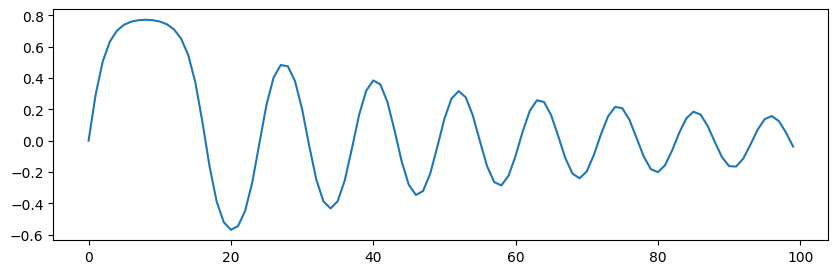

In [3]:
### generate series
### @Julia, define you own sequence here. Maybe the diffusion model?
from scipy.integrate import odeint

### Non-linear pendulum
ds_name = 'Non-linear pendulum'

# Time discretization
Nt = 100
tspan = np.linspace(0, 30, Nt)
# Damping parameter
lmbda = 0.1
# Define pendulum equation
w = 2

def dtheta(theta, t):
    return [theta[1], -np.sin(w**2 * theta[0]) - lmbda * theta[1]]

# Specific initial condition
theta_ic = [0, 1.05]   

# Solve the ODE
theta = odeint(dtheta, theta_ic, tspan)

# Extract the time-series
X = theta[:, 0]
Y = theta[:, 1]

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.plot(X)


In [4]:
prec = 2
settings=SerializerSettings(base=10, prec=prec, signed=True, time_sep=',', bit_sep='', minus_sign='-', fixed_length=False, max_val = 10)
def serialize(rescaled_array): 
    string_series = serialize_arr(rescaled_array, settings)
    return (string_series)  

def deserialize(string_series):
    return deserialize_str(string_series, settings, ignore_last=True)

In [5]:
### Final range is from 0.15 to 0.85
time_series = X
rescale_factor = 0.7
up_shift = 0.15
rescaled_array = (time_series-time_series.min())/(time_series.max()-time_series.min()) * rescale_factor + up_shift


In [6]:
rescaled_array

array([0.44701678, 0.60157851, 0.71191532, 0.77763119, 0.81400352,
       0.83354085, 0.84371528, 0.84855021, 0.85      , 0.84870522,
       0.84426593, 0.83512728, 0.81806092, 0.7871667 , 0.73262244,
       0.64149867, 0.50898897, 0.36141647, 0.24400012, 0.17529043,
       0.15      , 0.16216971, 0.21314596, 0.30777328, 0.43781052,
       0.56691759, 0.65748661, 0.69913811, 0.69497167, 0.64596526,
       0.55251396, 0.43032602, 0.31724773, 0.24483503, 0.2212036 ,
       0.24510326, 0.31492317, 0.42054933, 0.5317148 , 0.61297014,
       0.64784933, 0.63459542, 0.57546225, 0.48057837, 0.37743417,
       0.29981   , 0.265944  , 0.27920142, 0.33667938, 0.42612572,
       0.51989788, 0.58727154, 0.61216162, 0.59172084, 0.53056713,
       0.44446362, 0.36179915, 0.30896118, 0.29799984, 0.32970999,
       0.39627564, 0.4777776 , 0.54643861, 0.58160878, 0.57591747,
       0.53178327, 0.4615591 , 0.38846997, 0.33710133, 0.32157796,
       0.34453158, 0.39920882, 0.4683738 , 0.5281625 , 0.55962

In [7]:
serialize(rescaled_array)


'44,60,71,77,81,83,84,84,84,84,84,83,81,78,73,64,50,36,24,17,14,16,21,30,43,56,65,69,69,64,55,43,31,24,22,24,31,42,53,61,64,63,57,48,37,29,26,27,33,42,51,58,61,59,53,44,36,30,29,32,39,47,54,58,57,53,46,38,33,32,34,39,46,52,55,55,51,45,39,35,34,36,41,47,52,54,53,49,44,39,36,36,38,43,48,51,52,51,47,42,'

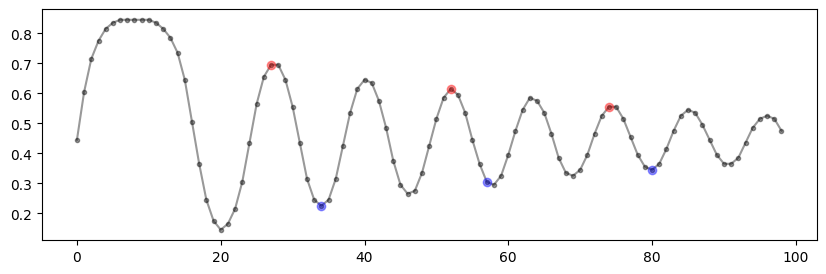

In [8]:
### visualize starting points to continue from

array_from_string = deserialize(serialize(rescaled_array))
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
axs.plot(array_from_string, color='black', marker = '.', alpha = 0.4)
# for idx in [27, 40, 52, 63, 74, 85]:
#     axs.plot(idx, array_from_string[idx], color='red', marker = 'o', alpha = 0.4)

for idx in [27, 52, 74]:
    axs.plot(idx, array_from_string[idx], color='red', marker = 'o', alpha = 0.4)

for idx in [34, 57, 80]:
    axs.plot(idx, array_from_string[idx], color='blue', marker = 'o', alpha = 0.4)    

In [9]:
# Continue from list of starting point

branch_start_list = [27, 40, 52, 63, 74, 85, 34, 57, 80]
branch_length = 20
model = '13b'
num_samples = 1
model, tokenizer = get_model_and_tokenizer(model)
branch_list = []
for starting in branch_start_list:
    input_string = serialize(rescaled_array[:starting])   
    print(input_string)
    prediction_str_list = llama_completion_fn(model, tokenizer,input_string,branch_length, settings,batch_size=1,num_samples=num_samples, temp=0.1)
    prediction_arr_list = [deserialize(prediction_str) for prediction_str in prediction_str_list]
    prediction_arr_padded_list = [np.pad(prediction_arr, (starting, 0), 'constant', constant_values=(np.nan,)) for prediction_arr in prediction_arr_list]
    branch_list += prediction_arr_padded_list

with open('pickled_files/branch_list_13b_2.pkl', 'wb') as f:
    pickle.dump(branch_list, f)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

44,60,71,77,81,83,84,84,84,84,84,83,81,78,73,64,50,36,24,17,14,16,21,30,43,56,65,


100%|██████████| 1/1 [00:46<00:00, 46.04s/it]


NameError: name 'branch_list' is not defined

### Load and plot

In [14]:
with open('pickled_files/branch_list_13b.pkl', 'rb') as f:
    branch_list = pickle.load(f)

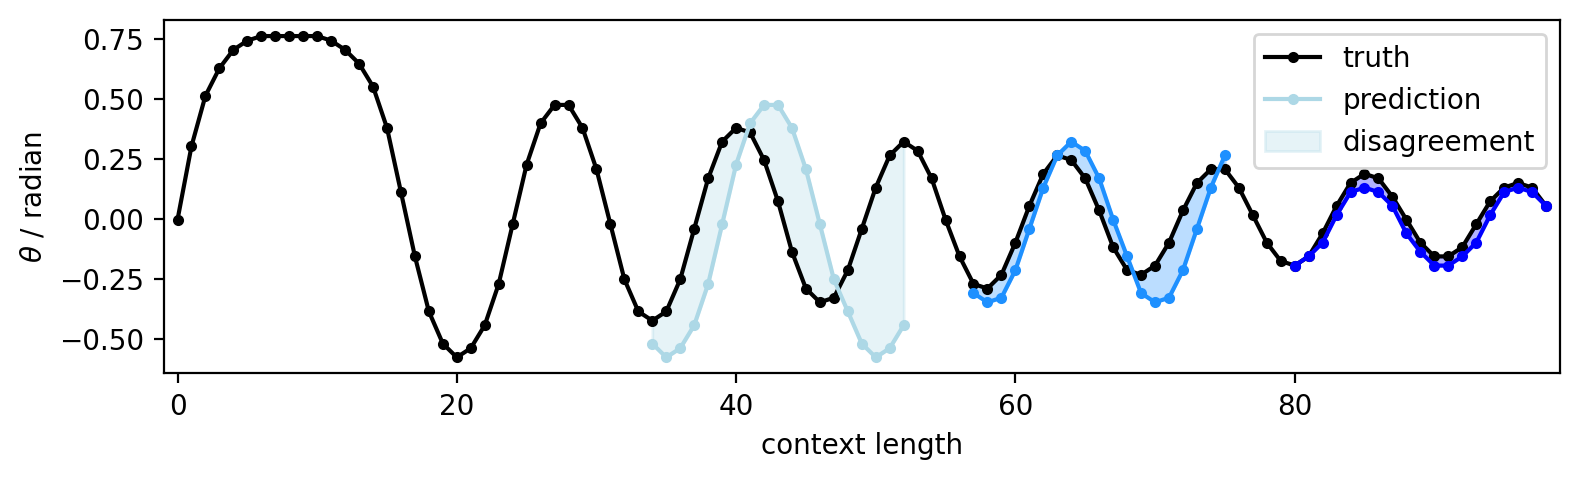

In [15]:
from matplotlib.ticker import FuncFormatter

# Your existing code
array_from_string = deserialize(serialize(rescaled_array))
fig, axs = plt.subplots(1, 1, figsize=(8, 2.5), dpi = 200)
array_from_string_rescaled = (array_from_string-up_shift)/rescale_factor*(time_series.max()-time_series.min())+time_series.min()
axs.plot(array_from_string_rescaled, 
         color='black', marker = '.', 
         alpha = 1, 
         label = "truth")

colors = ['lightblue', 'dodgerblue', 'blue']
for idx, branch in enumerate([branch_list[idx] for idx in [-3,-2,-1]]):
    branch_rescaled = (branch-up_shift)/rescale_factor*(time_series.max()-time_series.min())+time_series.min()
    if idx == 0:
        axs.plot(branch_rescaled, 
                 color=colors[idx], alpha = 1, marker = '.', 
                 label = 'prediction')
        axs.fill_between(range(len(branch_rescaled)), branch_rescaled, array_from_string_rescaled[:len(branch)], color=colors[idx], alpha=0.3,
                         label = 'disagreement')
    else:
        axs.plot(branch_rescaled, color=colors[idx], alpha = 1, marker = '.')
        axs.fill_between(range(len(branch_rescaled)), branch_rescaled, array_from_string_rescaled[:len(branch_rescaled)], color=colors[idx], alpha=0.3)

plt.xlabel("context length")
plt.ylabel(r"$\theta$ / radian")
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim(-1,99)
plt.savefig(figure_save_path / "auto_completion_plot")
plt.show()

In [ ]:
'[12,23,43], [34,75,23], [43, ..]'
'12,23,43; 12,35,53; 45..'